In [17]:
import os
import numpy as np
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from scipy.sparse import csr_matrix
import networkx as nx

from scipy.linalg import orthogonal_procrustes

import torch
import torch.optim as optim
from torch_geometric.data import Data

from sklearn.manifold import TSNE
from sklearn.datasets import make_moons  # 导入make_moons函数

from util import Net, GIN, GAT, stationary, reconstruct


np.random.seed(0)
torch.manual_seed(0)

n = 2000

def dG(A, B):
    A = A.T
    B = B.T
    S = A.T @ B
    U, Sigma, V = torch.svd(S)
    R = U @ V.T
    AR = A @ R
    return ((AR - B) ** 2).sum(1).mean()

def GIN_rec(m):
    DISTANCE = 0.5
    # 导入moon数据集
    x, y = make_moons(n_samples=n, noise=0.1, random_state=0) 
    # 分割训练集和测试机
    n_train = int(n * 1)
    train_ind = torch.randperm(n)[:n_train]
    test_ind = torch.LongTensor(list(set(np.arange(n)) - set(train_ind.tolist())))
    # K = int(np.sqrt(n) * np.log2(n) / 10) #作为隐藏输入
    D = pairwise_distances(x)# 邻接距离矩阵
    # 二值化，得到邻接矩阵
    A_binary = np.where(D <= DISTANCE, 1, 0)
    # A_binary
    # 获得所有的边，二元组格式
    row_indices, col_indices = np.where(A_binary == 1)
    edges = list(zip(row_indices, col_indices))

    # 转为tensor
    x = torch.tensor(x, dtype=torch.float)
    y = torch.tensor(y, dtype=torch.long)
    edges = torch.tensor(edges, dtype=torch.long).t().contiguous()
    data = Data(x=x, y=y, edge_index=edges)
    print(data)

    # 喂到GIN网络中
    net = GIN(m)
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    net.train()
    for epoch in range(100):
        ind = torch.eye(n)[:, torch.randperm(n)[:m]]
        # 将节点选择矩阵与特征矩阵连接在一起
        X_extended = torch.hstack([x, ind]) # 
        data = Data(x=X_extended, edge_index=edges)
        rec = net(data) # reconstruct
        print(x[train_ind].shape)
        loss = dG(x[train_ind], rec[train_ind]) #train loss
        print(f'Epoch {epoch + 1}, Loss: {float(loss)}')
        optimizer.zero_grad() # zero gradient
        loss.backward()
        optimizer.step()

    R, _ = orthogonal_procrustes(x.numpy(), rec.detach().numpy())
    rec_GIN = rec.detach().numpy() @ R.T
    loss_GIN = float(dG(x, rec))
    # 创建图形
    fig, ax = plt.subplots(1, 2, figsize=(14, 4))
    # ax两个画布
    ax[0].scatter(x[:, 0], x[:, 1], c=y, s=10, cmap='viridis', rasterized=True)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].set_facecolor('#eeeeee')
    txt = ax[0].text(0.05, 0.05, 'Ground Truth', color='k', fontsize=14, weight='bold', transform=ax[0].transAxes)
    txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='#eeeeee')])

    # 绘制 GIN 网络的重构结果
    ax[1].scatter(rec_GIN[:, 0], rec_GIN[:, 1], c=y, s=10, cmap='viridis', rasterized=True)
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    txt = ax[1].text(0.05, 0.05, f'GIN $d_G = {loss_GIN:.2f}$', color='k', fontsize=14, weight='bold', transform=ax[1].transAxes)
    txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])

    fig.subplots_adjust()

    if not os.path.exists('imgs'):
        os.mkdir('imgs')

    fig.savefig('imgs/semi_moon_GIN.png', bbox_inches='tight', dpi=300)

    plt.show()

In [18]:
GIN_rec(0)

Data(x=[2000, 2], edge_index=[2, 579986], y=[2000])
torch.Size([2000, 2])


RuntimeError: The size of tensor a (2000) must match the size of tensor b (2) at non-singleton dimension 1

Data(x=[2000, 2], edge_index=[2, 579986], y=[2000])
torch.Size([2000, 2])
torch.Size([2, 2])
Epoch 1, Loss: 1.3147363662719727
torch.Size([2000, 2])
torch.Size([2, 2])
Epoch 2, Loss: 1.259002923965454
torch.Size([2000, 2])
torch.Size([2, 2])
Epoch 3, Loss: 1.0002729892730713
torch.Size([2000, 2])
torch.Size([2, 2])
Epoch 4, Loss: 2.1842706203460693
torch.Size([2000, 2])
torch.Size([2, 2])
Epoch 5, Loss: 0.8019121289253235
torch.Size([2000, 2])
torch.Size([2, 2])
Epoch 6, Loss: 0.964799165725708
torch.Size([2000, 2])
torch.Size([2, 2])
Epoch 7, Loss: 1.216196894645691
torch.Size([2000, 2])
torch.Size([2, 2])
Epoch 8, Loss: 1.0672829151153564
torch.Size([2000, 2])
torch.Size([2, 2])
Epoch 9, Loss: 1.1366026401519775
torch.Size([2000, 2])
torch.Size([2, 2])
Epoch 10, Loss: 1.1511340141296387
torch.Size([2000, 2])
torch.Size([2, 2])
Epoch 11, Loss: 1.1311242580413818
torch.Size([2000, 2])
torch.Size([2, 2])
Epoch 12, Loss: 1.0482488870620728
torch.Size([2000, 2])
torch.Size([2, 2])
Epoch 1

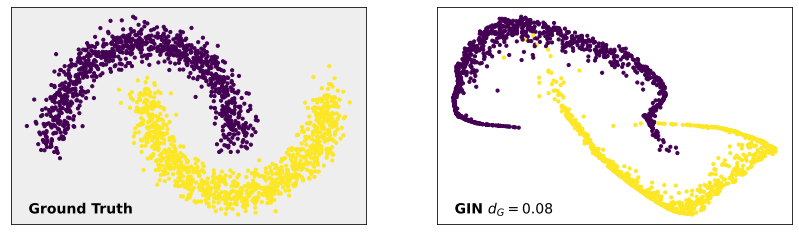

In [ ]:
GIN_rec(500)